 # Flight Prices EDA and Visualization Notebook

 This notebook performs exploratory data analysis on the flight prices dataset. It includes:
 - Downloading and unzipping the dataset using Kaggle.
 - Setting up PySpark, initializing a Spark context, and reading the CSV data.
 - Analyzing missing values across columns.
 - Computing and visualizing the ratio of total fare to base fare.
 - Grouping data by destination airport and plotting flight counts.
 - Analyzing boolean variables (e.g., isBasicEconomy).

 **Note:* Some cells (especially the ones involving Spark operations) may take a long time to run.

 ## Section 1: Downloading and Extracting the Dataset

 First, install the required packages, download the dataset from Kaggle, and unzip it.

In [1]:
!pip install kaggle
!kaggle datasets download -d dilwong/flightprices

!unzip -n flightprices.zip

!pip install pyspark

Dataset URL: https://www.kaggle.com/datasets/dilwong/flightprices
License(s): Attribution 4.0 International (CC BY 4.0)
100% 5.49G/5.51G [00:20<00:00, 319MB/s]
100% 5.51G/5.51G [00:20<00:00, 292MB/s]
Archive:  flightprices.zip
  inflating: itineraries.csv         
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849766 sha256=f2e833bf099a3c734a5e39fc0010cb69c752053a7a975e858502f34196c4940a
  Stored in directory: /root/.cache/pip/wheels/8d/28/22/5dbae8a8714ef046cebd320d0ef7c92f5383903cf854c15c0c
Successfully built pyspark


## Section 2: Importing Libraries and Setting Up PySpark

We import necessary libraries for data manipulation and visualization, and initialize the Spark context.


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F

# Stop any existing SparkContext to avoid conflicts
try:
    sc.stop()
except Exception as e:
    pass

# Initialize SparkContext and SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)
ss = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Section 3: Loading the Dataset with PySpark

We load the dataset into a Spark DataFrame using SQLContext.

In [3]:
# Read CSV file into a Spark DataFrame
df = sqlContext.read.csv('itineraries.csv', header=True)

# Show a few rows of the dataset
df.show()

# Display column names
print("Columns in the dataset:")
print(df.columns)

+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode| segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segments

## Section 4: Missing Values Analysis

We iterate over each column and count the number of missing (null) values.

In [4]:
# Warning: This cell may take a while if the dataset is large.
for col in df.columns:
    missing_count = df.filter(F.isnull(col)).count()
    print(f'There are {missing_count} missing values in the "{col}" column.')

There are 0 missing values in the "legId" column.
There are 0 missing values in the "searchDate" column.
There are 0 missing values in the "flightDate" column.
There are 0 missing values in the "startingAirport" column.
There are 0 missing values in the "destinationAirport" column.
There are 0 missing values in the "fareBasisCode" column.
There are 0 missing values in the "travelDuration" column.
There are 0 missing values in the "elapsedDays" column.
There are 0 missing values in the "isBasicEconomy" column.
There are 0 missing values in the "isRefundable" column.
There are 0 missing values in the "isNonStop" column.
There are 0 missing values in the "baseFare" column.
There are 0 missing values in the "totalFare" column.
There are 0 missing values in the "seatsRemaining" column.
There are 6094532 missing values in the "totalTravelDistance" column.
There are 0 missing values in the "segmentsDepartureTimeEpochSeconds" column.
There are 0 missing values in the "segmentsDepartureTimeRaw"

## Section 5: Fare Analysis – Ratio of Total Fare to Base Fare

We compute unique fare pairs and calculate the ratio of total fare to base fare. Then, we plot the distribution of these ratios.

In [5]:
# Group by baseFare and totalFare, then aggregate counts
fares = df.groupBy(['baseFare', 'totalFare']).agg({"*": "count"}).toPandas()

# Compute ratio of total fare to base fare and merge with count data
fareRates = pd.concat([
    pd.Series(np.array(fares['totalFare'], dtype=float) / np.array(fares['baseFare'], dtype=float)),
    fares
], axis=1)
fareRates.columns = ['rate', 'baseFare', 'totalFare', 'count']

# Display fareRates DataFrame
fareRates

,rate,baseFare,totalFare,count
0,1.395515,272.00,379.58,3400
1,1.129322,434.42,490.60,11024
2,1.105939,471.97,521.97,1
3,1.112913,770.24,857.21,571
4,1.133997,400.01,453.61,6375
...,...,...,...,...
105167,1.122166,564.07,632.98,1
105168,1.104512,1091.17,1205.21,1
105169,1.102083,1188.84,1310.20,1
105170,1.132086,353.86,400.60,1


### Plotting the Fare Ratio Distribution

We plot a histogram of the ratio using the count as weights.

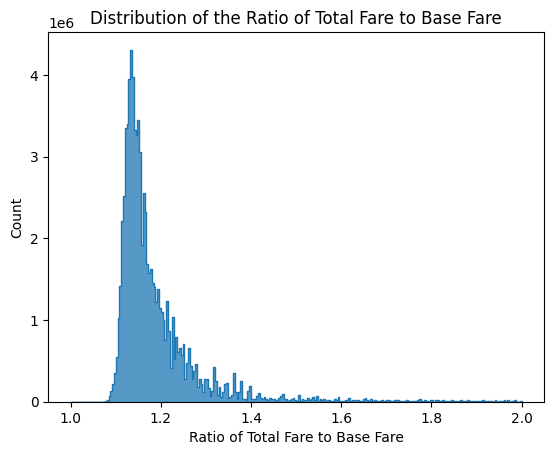

In [6]:
sns.histplot(data=fareRates, x='rate', weights='count', bins=250,
             binrange=[1, 2], element='step')
plt.title('Distribution of the Ratio of Total Fare to Base Fare')
plt.xlabel('Ratio of Total Fare to Base Fare')
plt.ylabel('Count')
plt.show()

## Section 6: Flights per Destination Airport

We group the data by destination airport to count the number of flights, then visualize the results.

In [7]:
# Group by destination airport and count instances
dAdf = df.groupBy("destinationAirport").agg({'*': 'count'}).toPandas()
dAdf

,destinationAirport,count(1)
0,OAK,3657923
1,LGA,6093450
2,BOS,5801538
3,EWR,4074698
4,DEN,4630696
5,IAD,3312681
6,CLT,5411448
7,MIA,5103390
8,DFW,5957280
9,SFO,5586204


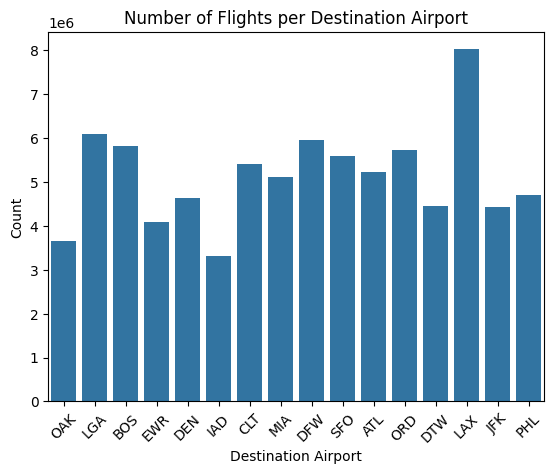

In [8]:
sns.barplot(data=dAdf, x='destinationAirport', y='count(1)')
plt.title('Number of Flights per Destination Airport')
plt.xlabel('Destination Airport')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Section 7: Boolean Variable Analysis

Finally, we analyze boolean variables such as isBasicEconomy by grouping and counting.

In [9]:
# Group by the isBasicEconomy column and count the records
df.groupby(df.isBasicEconomy).agg({'*': 'count'}).show()

+--------------+--------+
|isBasicEconomy|count(1)|
+--------------+--------+
|         False|70313487|
|          True|11825266|
+--------------+--------+



## End of Notebook

This notebook provided an end-to-end EDA for the flight prices dataset—from downloading and data loading to visualization and boolean analysis.